### This is Jason Kenner's Notebook for the Battle of Neighboorhoods project.

#### 1. First step is to import libraries

In [1]:
# import all required libraries
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.cluster import KMeans

!pip -q install folium
import folium

print('Libraries imported.')

Libraries imported.


#### 2. Second step is to obtain and prepare the postcode data, including coordinates.

In [2]:
# get postcode data for Australia
!wget -q -O 'australian_postcodes.csv' https://www.matthewproctor.com/Content/postcodes/australian_postcodes.csv
print('Data downloaded!')

Data downloaded!


In [3]:
# read the csv file into a dataframe
au_postcodes = pd.read_csv('australian_postcodes.csv')
au_postcodes.head()

,id,postcode,locality,state,long,lat,dc,type,status,sa3,sa3name,sa4,sa4name,region
0,230,200,ANU,ACT,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1
1,21820,200,Australian National University,ACT,149.118900,-35.277700,NaN,NaN,Added 19-Jan-2020,NaN,NaN,NaN,NaN,R1
2,232,800,DARWIN,NT,130.836680,-12.458684,NaN,NaN,Updated 6-Feb-2020,70101.0,Darwin City,701.0,Darwin,R1
3,233,801,DARWIN,NT,130.836680,-12.458684,NaN,NaN,Updated 25-Mar-2020 SA3,70101.0,Darwin City,701.0,Darwin,R1
4,234,804,PARAP,NT,130.873315,-12.428017,NaN,NaN,Updated 25-Mar-2020 SA3,70102.0,Darwin Suburbs,701.0,Darwin,R1


In [4]:
# clean up the df to remove unwanted columns
au_postcodes.drop(['id', 'dc', 'type', 'status', 'sa3', 'sa3name', 'sa4', 'sa4name', 'region'], axis=1, inplace=True)

# keep only Metropolitan Melbourne  postcodes: 3000-3207
melb_metro_pc = au_postcodes[(au_postcodes['postcode'] >= 3000) & (au_postcodes['postcode'] <= 3207)]
melb_metro_pc.head()

,postcode,locality,state,long,lat
6100,3000,MELBOURNE,VIC,144.956776,-37.817403
6101,3001,MELBOURNE,VIC,144.765920,-38.365017
6102,3002,EAST MELBOURNE,VIC,144.982207,-37.818517
6103,3003,WEST MELBOURNE,VIC,144.949592,-37.810871
6104,3004,MELBOURNE,VIC,144.970161,-37.844246


#### 3. Third step is to obtain and prepare the demographic data. This was obtained from the Australian Bureau of Statistics (ABS) and the csv file saved to GitHub.

In [5]:
# get demographic data for Australia. I saved the csv file to GitHub
!wget -q -O 'demographic.csv' https://raw.githubusercontent.com/jkenner440/IBM-Data-Science-Course/master/demographic.csv
print('Data downloaded!')

Data downloaded!


In [6]:
# read the demographic csv file into a dataframe
au_demograph = pd.read_csv('demographic.csv')
au_demograph.head()

,POA,Postal Area Code,SEIFAINDEXTYPE,Index Type,SEIFA_MEASURE,Measure,TIME,Time,Value,Flag Codes,Flags
0,800,800,IEO,Index of Education and Occupation,SCORE,Score,2016.0,2016.0,1089.0,NaN,NaN
1,800,800,IEO,Index of Education and Occupation,RWAR,Rank within Australia,2016.0,2016.0,2287.0,NaN,NaN
2,800,800,IEO,Index of Education and Occupation,RWAD,Rank within Australia - Decile,2016.0,2016.0,9.0,NaN,NaN
3,800,800,IEO,Index of Education and Occupation,RWAP,Rank within Australia - Percentile,2016.0,2016.0,87.0,NaN,NaN
4,800,800,IEO,Index of Education and Occupation,RWSR,Rank within State or Territory,2016.0,2016.0,33.0,NaN,NaN


##### Create seperate dataframes for three index types against each suburb within the Melbourne Metropolitan area. These will inform the clustering later.

In [7]:
# first dataframe: Index of Education and Occupation
# keep only Index of Education and Occupation
ieo = au_demograph[au_demograph['SEIFAINDEXTYPE'] == 'IEO']

# keep only Rank within State or Territory
ieo = ieo[ieo['SEIFA_MEASURE'] == 'RWSD']

# keep only Metropolitan Melbourne postcodes: 3000-3207
ieo = ieo[(ieo['Postal Area Code'] >= 3000) & (ieo['Postal Area Code'] <= 3207)]

# clean up the df to remove unwanted columns
ieo.drop(['POA', 'SEIFAINDEXTYPE', 'Index Type', 'SEIFA_MEASURE', 'Measure', 'TIME', 'Time', 'Flag Codes', 'Flags'], axis=1, inplace=True)

# rename columns
ieo.rename(columns={'Postal Area Code':'postcode', 'Value':'ieo rank'}, inplace=True)
    
ieo.head()

,postcode,ieo rank
6515,3000,10.0
6525,3002,10.0
6535,3003,10.0
6545,3004,10.0
6555,3005,10.0


In [8]:
# second dataframe: Index of Economic Resources
# keep only Index of Economic Resources
ier = au_demograph[au_demograph['SEIFAINDEXTYPE'] == 'IER']

# keep only Rank within State or Territory
ier = ier[ier['SEIFA_MEASURE'] == 'RWSD']

# keep only Metropolitan Melbourne postcodes: 3000-3207
ier = ier[(ier['Postal Area Code'] >= 3000) & (ier['Postal Area Code'] <= 3207)]

# clean up the df to remove unwanted columns
ier.drop(['POA', 'SEIFAINDEXTYPE', 'Index Type', 'SEIFA_MEASURE', 'Measure', 'TIME', 'Time', 'Flag Codes', 'Flags'], axis=1, inplace=True)

# rename columns
ier.rename(columns={'Postal Area Code':'postcode', 'Value':'ier rank'}, inplace=True)
    
ier.head()

,postcode,ier rank
26379,3072,2.0
26744,3113,10.0
26781,3032,3.0
26884,3199,3.0
26893,3127,10.0


In [9]:
# third dataframe: Index of Social Advantage and Disadvantage
# keep only Index of Relative Socio-economic Advantage and Disadvantage
irsad = au_demograph[au_demograph['SEIFAINDEXTYPE'] == 'IRSAD']

# keep only Rank within State or Territory
irsad = irsad[irsad['SEIFA_MEASURE'] == 'RWSD']

# keep only Metropolitan Melbourne postcodes: 3000-3207
irsad = irsad[(irsad['Postal Area Code'] >= 3000) & (irsad['Postal Area Code'] <= 3207)]

# clean up the df to remove unwanted columns
irsad.drop(['POA', 'SEIFAINDEXTYPE', 'Index Type', 'SEIFA_MEASURE', 'Measure', 'TIME', 'Time', 'Flag Codes', 'Flags'], axis=1, inplace=True)

# rename columns
irsad.rename(columns={'Postal Area Code':'postcode', 'Value':'irsad rank'}, inplace=True)

irsad.head()

,postcode,irsad rank
52629,3170,8.0
52718,3167,7.0
52750,3128,8.0
52905,3074,1.0
53171,3042,7.0


In [10]:
# combine all the demographic dataframes into one
from functools import reduce

dem_list = [ieo, ier, irsad]
dem_comb = reduce(lambda  left,right: pd.merge(left,right,on=['postcode'],
                                            how='outer'), dem_list)
dem_comb.head()

,postcode,ieo rank,ier rank,irsad rank
0,3000,10.0,1.0,8.0
1,3002,10.0,4.0,10.0
2,3003,10.0,1.0,10.0
3,3004,10.0,2.0,10.0
4,3005,10.0,1.0,10.0


#### 4. Now the postcode and demographic data is compiled, it is merged and cleaned.

In [11]:
# combine the demographic and postcode dataframes and view the new table
melb_metro_comb = pd.merge(left=melb_metro_pc, right=dem_comb, how='left', left_on='postcode', right_on='postcode')
melb_metro_comb.head(10)

,postcode,locality,state,long,lat,ieo rank,ier rank,irsad rank
0,3000,MELBOURNE,VIC,144.956776,-37.817403,10.0,1.0,8.0
1,3001,MELBOURNE,VIC,144.765920,-38.365017,NaN,NaN,NaN
2,3002,EAST MELBOURNE,VIC,144.982207,-37.818517,10.0,4.0,10.0
3,3003,WEST MELBOURNE,VIC,144.949592,-37.810871,10.0,1.0,10.0
4,3004,MELBOURNE,VIC,144.970161,-37.844246,10.0,2.0,10.0
5,3004,ST KILDA ROAD CENTRAL,VIC,144.970161,-37.844246,10.0,2.0,10.0
6,3004,ST KILDA ROAD MELBOURNE,VIC,0.000000,0.000000,10.0,2.0,10.0
7,3005,WORLD TRADE CENTRE,VIC,144.950858,-37.824608,10.0,1.0,10.0
8,3006,SOUTH WHARF,VIC,144.952074,-37.825287,10.0,1.0,10.0
9,3006,SOUTHBANK,VIC,144.965926,-37.823258,10.0,1.0,10.0


In [12]:
# drop rows that have rank 'Nan' or have 0 for long or lat and view the table again to confirm
melb_metro_comb = melb_metro_comb[(melb_metro_comb['long'] >= 1)]
melb_metro = melb_metro_comb.dropna().reset_index(drop=True)
melb_metro.head()

,postcode,locality,state,long,lat,ieo rank,ier rank,irsad rank
0,3000,MELBOURNE,VIC,144.956776,-37.817403,10.0,1.0,8.0
1,3002,EAST MELBOURNE,VIC,144.982207,-37.818517,10.0,4.0,10.0
2,3003,WEST MELBOURNE,VIC,144.949592,-37.810871,10.0,1.0,10.0
3,3004,MELBOURNE,VIC,144.970161,-37.844246,10.0,2.0,10.0
4,3004,ST KILDA ROAD CENTRAL,VIC,144.970161,-37.844246,10.0,2.0,10.0


#### 5. Next step is to visualise the suburb coordinates on a map.

In [13]:
# define Melbourne as the user_agent for geocoder and get coordinates
address = 'Melbourne, VIC'

geolocator = Nominatim(user_agent="jk_student")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Melbourne are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Melbourne are -37.8142176, 144.9631608.


In [14]:
# create map of Melbourne using latitude and longitude values
map_melbourne = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, locality, postcode in zip(melb_metro['lat'], melb_metro['long'], melb_metro['locality'], melb_metro['postcode']):
    label = '{}, {}'.format(locality, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_melbourne)  
    
map_melbourne

#### 6. This analysis is only of inner Melbourne suburbs. So, that data needs to be reduced to include only subrubs within 5kms of the CBD. The data was obtained from FreeMapTools and saved to GitHub.

In [15]:
# get a subset of postcodes within 5km of Melbourne. I saved the csv file to GitHub
!wget -q -O 'inner5.csv' https://raw.githubusercontent.com/jkenner440/IBM-Data-Science-Course/master/inner5km.csv
print('Data downloaded!')

Data downloaded!


In [16]:
# read the demographic csv file into a dataframe
inner5 = pd.read_csv('inner5.csv')
inner5.head()

,postcode
0,3000
1,3002
2,3003
3,3004
4,3005


In [17]:
# reduce the metro dataframe so that only the inner 5km postcodes are represented
melb_inner = melb_metro[melb_metro['postcode'].isin(inner5['postcode'])].reset_index(drop=True)
melb_inner.head()

,postcode,locality,state,long,lat,ieo rank,ier rank,irsad rank
0,3000,MELBOURNE,VIC,144.956776,-37.817403,10.0,1.0,8.0
1,3002,EAST MELBOURNE,VIC,144.982207,-37.818517,10.0,4.0,10.0
2,3003,WEST MELBOURNE,VIC,144.949592,-37.810871,10.0,1.0,10.0
3,3004,MELBOURNE,VIC,144.970161,-37.844246,10.0,2.0,10.0
4,3004,ST KILDA ROAD CENTRAL,VIC,144.970161,-37.844246,10.0,2.0,10.0


#### 7. Now visualise the new data frame on a map.

In [18]:
# create map of Inner Melbourne using latitude and longitude values
map_inner_melbourne = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, locality, postcode in zip(melb_inner['lat'], melb_inner['long'], melb_inner['locality'], melb_inner['postcode']):
    label = '{}, {}'.format(locality, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_inner_melbourne)  
    
map_inner_melbourne

#### 8. Now that all the postcode and demographic data for the inner suburbs of Melbourne has been prepared, it can be used to call the venue data from Foursquare.

In [19]:
# define Foursquare credentials and version
CLIENT_ID = 'T143OVDEI2IYO2B03R1Y14MAY5ZWRO0DCZAPHYAKGKCMJ1HH'
CLIENT_SECRET = 'MQVHIOWOZGQS3KIC0P1PIPRQTDO4BOVCDFD31SDWIDCLGF01'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: T143OVDEI2IYO2B03R1Y14MAY5ZWRO0DCZAPHYAKGKCMJ1HH
CLIENT_SECRET:MQVHIOWOZGQS3KIC0P1PIPRQTDO4BOVCDFD31SDWIDCLGF01


In [20]:
# get top venues in within 10km of Melbourne

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # define extra terms
        LIMIT=100
        categoryId = '4bf58dd8d48988d116941735'
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            categoryId,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Locality', 
                'Locality lat', 
                'Locality long', 
                'Bars',
                'Bar lat', 
                'Bar long',
                'Bar category']

    return(nearby_venues)
    
melbourne_bars = getNearbyVenues(names=melb_inner['locality'],
                           latitudes=melb_inner['lat'],
                           longitudes=melb_inner['long']
                          )

MELBOURNE
EAST MELBOURNE
WEST MELBOURNE
MELBOURNE
ST KILDA ROAD CENTRAL
WORLD TRADE CENTRE
SOUTH WHARF
SOUTHBANK
DOCKLANDS
FOOTSCRAY
SEDDON
SEDDON WEST
FLEMINGTON
KENSINGTON
ROYAL MELBOURNE HOSPITAL
HOTHAM HILL
NORTH MELBOURNE
MELBOURNE UNIVERSITY
PARKVILLE
CARLTON
CARLTON SOUTH
CARLTON NORTH
PRINCES HILL
FITZROY
COLLINGWOOD
COLLINGWOOD NORTH
ABBOTSFORD
CLIFTON HILL
FITZROY NORTH
BURNLEY
BURNLEY NORTH
CREMORNE
RICHMOND
RICHMOND EAST
RICHMOND NORTH
RICHMOND SOUTH
VICTORIA GARDENS
CHAPEL STREET NORTH
DOMAIN ROAD PO
SOUTH YARRA
SOUTH MELBOURNE
SOUTH MELBOURNE DC
ALBERT PARK
MIDDLE PARK
GARDEN CITY
PORT MELBOURNE


In [21]:
# check the size of the dataframe
print(melbourne_bars.shape)
melbourne_bars

(443, 7)


,Locality,Locality lat,Locality long,Bars,Bar lat,Bar long,Bar category
0,MELBOURNE,-37.817403,144.956776,Dikstein's Corner Bar,-37.816189,144.960353,Bar
1,MELBOURNE,-37.817403,144.956776,The Irish Times,-37.816135,144.960563,Bar
2,MELBOURNE,-37.817403,144.956776,MoVida Terraza,-37.814688,144.958567,Bar
3,MELBOURNE,-37.817403,144.956776,Bonnie Coffee Brewers,-37.818153,144.957636,Coffee Shop
4,MELBOURNE,-37.817403,144.956776,Patricia Coffee Brewers,-37.814598,144.958350,Coffee Shop
5,MELBOURNE,-37.817403,144.956776,The Lui Bar,-37.819067,144.957739,Cocktail Bar
6,MELBOURNE,-37.817403,144.956776,Shamble Coffee Brewers,-37.816056,144.960779,Café
7,MELBOURNE,-37.817403,144.956776,The Deck,-37.820254,144.957515,Bar
8,MELBOURNE,-37.817403,144.956776,Syracuse,-37.816207,144.960253,Restaurant
9,MELBOURNE,-37.817403,144.956776,Saint & Rogue,-37.817512,144.955491,Bar


#### 9. Now visualise the bars on a map.

In [23]:
# create map of Inner Melbourne using latitude and longitude values and plot venues
map_melbourne_bars = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, venue in zip(melbourne_bars['Bar lat'], melbourne_bars['Bar long'], melbourne_bars['Bars']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_melbourne_bars)  
    
map_melbourne_bars

#### 10. Prepare the bars data for clustering

In [39]:
# ceate a dataframe with number of bars for each locality
group_bars = melbourne_bars.groupby('Locality').count()
group_bars.head()

,Locality lat,Locality long,Bars,Bar lat,Bar long,Bar category
Locality,,,,,,
ABBOTSFORD,5,5,5,5,5,5
ALBERT PARK,2,2,2,2,2,2
BURNLEY,10,10,10,10,10,10
BURNLEY NORTH,5,5,5,5,5,5
CARLTON,17,17,17,17,17,17


In [40]:
# combine the dataframes and view the new table
melb_bars = pd.merge(left=melb_inner, right=group_bars, how='left', left_on='locality', right_on='Locality')
melb_bars.head()

,postcode,locality,state,long,lat,ieo rank,ier rank,irsad rank,Locality lat,Locality long,Bars,Bar lat,Bar long,Bar category
0,3000,MELBOURNE,VIC,144.956776,-37.817403,10.0,1.0,8.0,54.0,54.0,54.0,54.0,54.0,54.0
1,3002,EAST MELBOURNE,VIC,144.982207,-37.818517,10.0,4.0,10.0,6.0,6.0,6.0,6.0,6.0,6.0
2,3003,WEST MELBOURNE,VIC,144.949592,-37.810871,10.0,1.0,10.0,6.0,6.0,6.0,6.0,6.0,6.0
3,3004,MELBOURNE,VIC,144.970161,-37.844246,10.0,2.0,10.0,54.0,54.0,54.0,54.0,54.0,54.0
4,3004,ST KILDA ROAD CENTRAL,VIC,144.970161,-37.844246,10.0,2.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# clean up the df to remove unwanted columns
melb_bars.drop(['state', 'Locality lat', 'Locality long', 'Bar lat', 'Bar long', 'Bar category'], axis=1, inplace=True)

# drop rows with NaN values
melb_bars_grouped = melb_bars.dropna().reset_index(drop=True)

# view the new dataframe
melb_bars_grouped.head()

,postcode,locality,long,lat,ieo rank,ier rank,irsad rank,Bars
0,3000,MELBOURNE,144.956776,-37.817403,10.0,1.0,8.0,54.0
1,3002,EAST MELBOURNE,144.982207,-37.818517,10.0,4.0,10.0,6.0
2,3003,WEST MELBOURNE,144.949592,-37.810871,10.0,1.0,10.0,6.0
3,3004,MELBOURNE,144.970161,-37.844246,10.0,2.0,10.0,54.0
4,3005,WORLD TRADE CENTRE,144.950858,-37.824608,10.0,1.0,10.0,11.0


#### 11. Visualise the new data by plotting each of the three demographic data figures against total bars for each suburb.

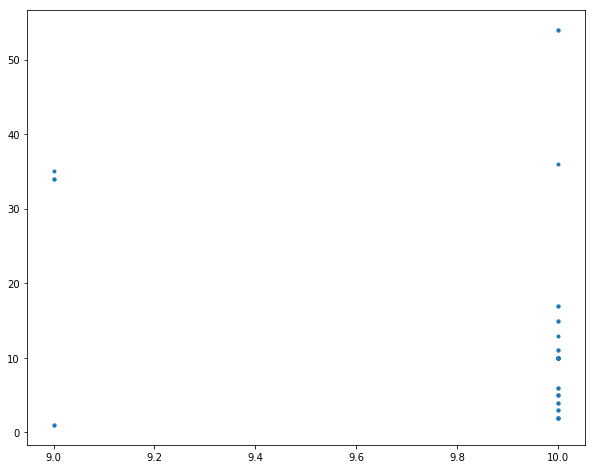

In [27]:
# plot Index of Education and Occupation and Bars to see if there is any trend in demographic data and number of bars
plt.figure(figsize=(10, 8))
plt.scatter(melb_bars_grouped['ieo rank'], melb_bars_grouped['Bars'], marker='.')

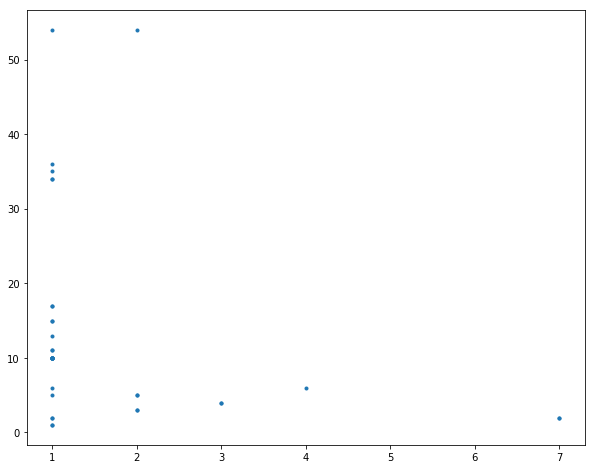

In [28]:
# plot Index of Economic Resources and Bars to see if there is any trend in demographic data and number of bars
plt.figure(figsize=(10, 8))
plt.scatter(melb_bars_grouped['ier rank'], melb_bars_grouped['Bars'], marker='.')

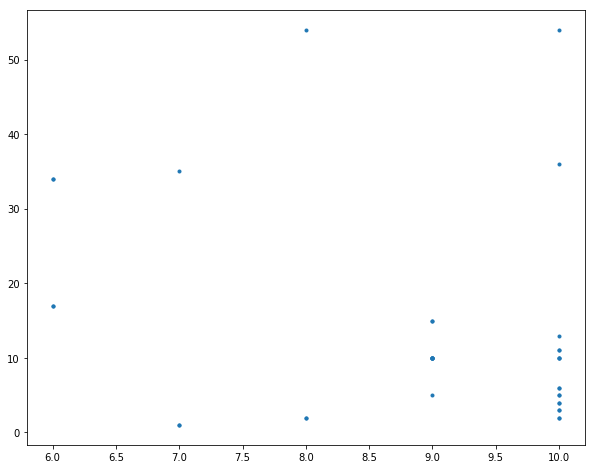

In [29]:
# plot Index of Social Advantage and Disadvantage and Bars to see if there is any trend in demographic data and number of bars
plt.figure(figsize=(10, 8))
plt.scatter(melb_bars_grouped['irsad rank'], melb_bars_grouped['Bars'], marker='.')

#### 12. Perform clustering to compare the number of bars in like suburbs.

In [30]:
# cluster using k-means into 5 clusters
# set number of clusters
kclusters = 5

melb_grouped_clustering = melb_bars_grouped.drop(['postcode', 'locality', 'long', 'lat', 'Bars'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(melb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 3, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int32)

In [31]:
# add clustering labels melb bars grouped dataframe
melb_bars_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
melb_bars_grouped.head()

,Cluster Labels,postcode,locality,long,lat,ieo rank,ier rank,irsad rank,Bars
0,4,3000,MELBOURNE,144.956776,-37.817403,10.0,1.0,8.0,54.0
1,3,3002,EAST MELBOURNE,144.982207,-37.818517,10.0,4.0,10.0,6.0
2,0,3003,WEST MELBOURNE,144.949592,-37.810871,10.0,1.0,10.0,6.0
3,0,3004,MELBOURNE,144.970161,-37.844246,10.0,2.0,10.0,54.0
4,0,3005,WORLD TRADE CENTRE,144.950858,-37.824608,10.0,1.0,10.0,11.0


#### 13. Visualise the new clusters on a map.

In [32]:
# visualize the clusters on a map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(melb_bars_grouped['lat'], melb_bars_grouped['long'], melb_bars_grouped['locality'], melb_bars_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 14. Finally, sort the data by cluster and then by number of bars to look for clusters with large variations and identify potential locations for new bars.

In [34]:
# sort dataframe by cluster labels and number of bars to identify potential localities for opening a bar
melb_bars_grouped.sort_values(by=['Cluster Labels', 'Bars'])

,Cluster Labels,postcode,locality,long,lat,ieo rank,ier rank,irsad rank,Bars
15,0,3054,CARLTON NORTH,144.967240,-37.786971,10.0,2.0,10.0,3.0
16,0,3054,PRINCES HILL,144.967240,-37.786971,10.0,2.0,10.0,3.0
10,0,3050,ROYAL MELBOURNE HOSPITAL,144.954581,-37.800324,10.0,2.0,10.0,5.0
20,0,3067,ABBOTSFORD,144.998203,-37.803515,10.0,2.0,10.0,5.0
2,0,3003,WEST MELBOURNE,144.949592,-37.810871,10.0,1.0,10.0,6.0
31,0,3141,CHAPEL STREET NORTH,144.991264,-37.840679,10.0,1.0,10.0,10.0
32,0,3141,DOMAIN ROAD PO,144.991264,-37.840679,10.0,1.0,10.0,10.0
33,0,3141,SOUTH YARRA,144.991264,-37.840679,10.0,1.0,10.0,10.0
4,0,3005,WORLD TRADE CENTRE,144.950858,-37.824608,10.0,1.0,10.0,11.0
7,0,3008,DOCKLANDS,144.948039,-37.814719,10.0,1.0,10.0,11.0


### Based on this analysis, Carlton North, Princes Hill, Flemington, Kensington, Hotham Hill and North Melbourne appear to be good candidates for opening a bar.